# Traffic Sign Recognition using Deep Learning
# GTSRB Dataset (German Traffic Sign Recognition Benchmark)
#
# Copyright 2017 Alex Staravoitau (https://github.com/alexstaravoitau/traffic-signs)
# Modified 2025 by Whyet Badri
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
# Original Source: https://github.com/alexstaravoitau/traffic-signs
# Original Notebook: Traffic_Signs_Recognition.ipynb
#
# Modifications made by Whyet Badri:
#   - Replaced custom CNN architecture with EfficientNetB0 transfer learning
#   - Updated to TensorFlow 2.x / Keras API
#   - Added two-phase training (frozen base, then fine-tuning)
#   - Modified data pipeline for local environment
#   - Added class weighting for imbalanced dataset handling
#   - Updated evaluation metrics and visualization
#
# References:
#
# Dataset:
#   Stallkamp, J., Schlipsing, M., Salmen, J., & Igel, C. (2012).
#   Man vs. Computer: Benchmarking Machine Learning Algorithms for
#   Traffic Sign Recognition. Neural Networks, 32, 323-332.
#
#   Stallkamp, J., Schlipsing, M., Salmen, J., & Igel, C. (2011).
#   The German Traffic Sign Recognition Benchmark: A Multi-class
#   Classification Competition. IJCNN, 1453-1460. IEEE Press.
#
#   URL: https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370
#
# EfficientNet Architecture:
#   Tan, M., & Le, Q. V. (2019). EfficientNet: Rethinking Model Scaling
#   for Convolutional Neural Networks. ICML, 6105-6114.
#
# Transfer Learning:
#   TensorFlow Team. Transfer Learning and Fine-tuning.
#   https://www.tensorflow.org/tutorials/images/transfer_learning

In [29]:
# ------------------------------------------------------
# Import TensorFlow
# ------------------------------------------------------
# TensorFlow is the deep learning framework used for building
# and training the neural network model.

import tensorflow as tf

print(f"TensorFlow Version: {tf.__version__}")

# Check for GPU availability and configure memory allocation
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Found: {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU memory growth enabled")
else:
    print("Warning: No GPU found. Training will be slow.")

TensorFlow Version: 2.10.0
GPU Found: /physical_device:GPU:0
GPU memory growth enabled


In [30]:
# ------------------------------------------------------
# Configuration
# ------------------------------------------------------
# Central configuration class containing all hyperparameters and file paths.
# Centralizing settings makes it easy to experiment with different values.
#
# Adapted from alexstaravoitau/traffic-signs
# https://github.com/alexstaravoitau/traffic-signs

import os

class Config:
    """
    Hyperparameters and paths for the traffic sign recognition model.
    
    Attributes:
        DATASET_PATH: Path to dataset folder
        IMAGE_SIZE: Input dimensions for the model (height, width)
        BATCH_SIZE: Number of samples per training batch
        EPOCHS_PHASE1: Training epochs with frozen base model
        EPOCHS_PHASE2: Training epochs during fine-tuning
        LEARNING_RATE: Initial learning rate for Phase 1
        FINE_TUNE_LR: Reduced learning rate for Phase 2
    """
    
    # Dataset path
    DATASET_PATH = r"C:\Users\USER-PC\Documents\TrafficSignProject"
    
    # Dataset archive files
    TRAIN_ARCHIVE = os.path.join(DATASET_PATH, "GTSRB_Final_Training_Images.zip")
    TEST_ARCHIVE = os.path.join(DATASET_PATH, "GTSRB_Final_Test_Images.zip")
    TEST_GT_ARCHIVE = os.path.join(DATASET_PATH, "GTSRB_Final_Test_GT.zip")
    
    # Working directories
    WORK_DIR = os.path.join(DATASET_PATH, "extracted")
    TRAIN_DIR = os.path.join(WORK_DIR, "train")
    TEST_DIR = os.path.join(WORK_DIR, "test")
    VALID_DIR = os.path.join(WORK_DIR, "valid")
    MODEL_DIR = os.path.join(DATASET_PATH, "models")
    
    # Image preprocessing
    IMAGE_SIZE = (128, 128)
    CHANNELS = 3
    INPUT_SHAPE = (*IMAGE_SIZE, CHANNELS)
    
    # Training hyperparameters
    BATCH_SIZE = 64
    EPOCHS_PHASE1 = 25
    EPOCHS_PHASE2 = 40
    LEARNING_RATE = 0.0005
    FINE_TUNE_LR = 0.00005
    FINE_TUNE_LAYERS = 50
    
    # Data augmentation parameters
    # Reference: Shorten & Khoshgoftaar (2019). A Survey on Image Data
    # Augmentation for Deep Learning. Journal of Big Data, 6(1), 1-48.
    ROTATION_RANGE = 12
    ZOOM_RANGE = 0.12
    SHIFT_RANGE = 0.08
    BRIGHTNESS_RANGE = (0.9, 1.1)
    
    # Dataset information
    NUM_CLASSES = 43
    TRAIN_IMAGES = 39209
    TEST_IMAGES = 12630


# Human-readable names for the 43 traffic sign classes
# These correspond to class indices 0-42 in the GTSRB dataset
#
# Source: GTSRB Dataset Documentation
# Stallkamp et al. (2011)
CLASS_NAMES = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing (>3.5t)",
    "Right-of-way intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles >3.5t prohibited",
    "No entry",
    "General caution",
    "Dangerous curve left",
    "Dangerous curve right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End speed + passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End no passing (>3.5t)"
]

# Create necessary directories
os.makedirs(Config.WORK_DIR, exist_ok=True)
os.makedirs(Config.MODEL_DIR, exist_ok=True)

print(f"Dataset path: {Config.DATASET_PATH}")
print(f"Image size: {Config.IMAGE_SIZE}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Number of classes: {Config.NUM_CLASSES}")

Dataset path: C:\Users\USER-PC\Documents\TrafficSignProject
Image size: (128, 128)
Batch size: 64
Number of classes: 43


In [31]:
# ------------------------------------------------------
# Import Libraries
# ------------------------------------------------------
# Import all required libraries for data processing, model building,
# training, and evaluation.

import json
import shutil
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import csv

warnings.filterwarnings('ignore')

# Keras imports for neural network construction
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Scikit-learn imports for evaluation metrics
# Reference: Pedregosa et al. (2011). Scikit-learn: Machine Learning
# in Python. JMLR 12, 2825-2830.
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully")

All libraries imported successfully


In [32]:
# ------------------------------------------------------
# Extract Dataset
# ------------------------------------------------------
# Extract the compressed dataset files into the working directory.

def extract_zip(archive_path, extract_to):
    """
    Extract a ZIP archive to the specified directory.
    
    Args:
        archive_path: Path to the ZIP file
        extract_to: Directory to extract contents into
    """
    print(f"Extracting {os.path.basename(archive_path)}...")
    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete")


print("Extracting GTSRB Dataset")

# Verify files exist
files_ok = True
for f in [Config.TRAIN_ARCHIVE, Config.TEST_ARCHIVE, Config.TEST_GT_ARCHIVE]:
    if os.path.exists(f):
        print(f"Found: {os.path.basename(f)}")
    else:
        print(f"Missing: {f}")
        files_ok = False

if not files_ok:
    print("\nError: Dataset files not found!")
    print(f"Please place these files in: {Config.DATASET_PATH}")
    print("  - GTSRB_Final_Training_Images.zip")
    print("  - GTSRB_Final_Test_Images.zip")
    print("  - GTSRB_Final_Test_GT.zip")
else:
    # Extract training images
    if not os.path.exists(os.path.join(Config.WORK_DIR, "GTSRB")):
        extract_zip(Config.TRAIN_ARCHIVE, Config.WORK_DIR)
    else:
        print("Training images already extracted")
    
    # Extract test images
    extract_zip(Config.TEST_ARCHIVE, Config.WORK_DIR)
    
    # Extract test ground truth
    extract_zip(Config.TEST_GT_ARCHIVE, Config.WORK_DIR)
    
    print("All files extracted successfully")

Extracting GTSRB Dataset
Found: GTSRB_Final_Training_Images.zip
Found: GTSRB_Final_Test_Images.zip
Found: GTSRB_Final_Test_GT.zip
Training images already extracted
Extracting GTSRB_Final_Test_Images.zip...
Extraction complete
Extracting GTSRB_Final_Test_GT.zip...
Extraction complete
All files extracted successfully


In [33]:
# ------------------------------------------------------
# Organize Training Data
# ------------------------------------------------------
# The GTSRB training data uses folder names 00000-00042 for classes.
# This section copies images to folders named 0-42 for consistency
# with Keras data generators.
#
# Adapted from alexstaravoitau/traffic-signs
# https://github.com/alexstaravoitau/traffic-signs

def organize_gtsrb_training(source_base, dest_dir):
    """
    Organize GTSRB training images into class-labeled folders.
    
    The original dataset uses zero-padded folder names (00000-00042).
    This function creates simplified folder names (0-42) that work
    seamlessly with Keras ImageDataGenerator.
    
    Args:
        source_base: Root directory containing extracted GTSRB data
        dest_dir: Destination directory for organized images
        
    Returns:
        int: Total number of images organized
    """
    print("Organizing training images...")
    
    source_dir = os.path.join(source_base, "GTSRB", "Final_Training", "Images")
    
    if not os.path.exists(source_dir):
        source_dir = os.path.join(source_base, "Final_Training", "Images")
    
    if not os.path.exists(source_dir):
        for root, dirs, files in os.walk(source_base):
            if "Images" in dirs and "Final_Training" in root:
                source_dir = os.path.join(root, "Images")
                break
    
    os.makedirs(dest_dir, exist_ok=True)
    total_images = 0
    
    for class_folder in sorted(os.listdir(source_dir)):
        class_path = os.path.join(source_dir, class_folder)
        
        if not os.path.isdir(class_path):
            continue
        
        class_id = int(class_folder)
        class_name = str(class_id)
        
        dest_class = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class, exist_ok=True)
        
        for img_file in os.listdir(class_path):
            if img_file.endswith('.ppm'):
                src = os.path.join(class_path, img_file)
                dst = os.path.join(dest_class, img_file)
                if not os.path.exists(dst):
                    shutil.copy2(src, dst)
                total_images += 1
    
    print(f"Organized {total_images} training images into {Config.NUM_CLASSES} classes")
    return total_images


print("Organizing Training Data")
train_count = organize_gtsrb_training(Config.WORK_DIR, Config.TRAIN_DIR)

Organizing Training Data
Organizing training images...
Organized 39209 training images into 43 classes


In [34]:
# ------------------------------------------------------
# Organize Test Data
# ------------------------------------------------------
# Test images are in a flat directory with labels in a CSV file.
# This section reads the ground truth and organizes images into
# class folders matching the training structure.
#
# Adapted from alexstaravoitau/traffic-signs
# https://github.com/alexstaravoitau/traffic-signs

def organize_gtsrb_test(work_dir, dest_dir):
    """
    Organize GTSRB test images using the ground truth CSV file.
    
    Unlike training data, test images are stored in a single directory.
    Class labels are provided in GT-final_test.csv with columns:
    Filename, Width, Height, Roi.X1, Roi.Y1, Roi.X2, Roi.Y2, ClassId
    
    Args:
        work_dir: Directory containing extracted test data and CSV
        dest_dir: Destination directory for organized test images
        
    Returns:
        int: Total number of images organized
    """
    print("Organizing test images...")
    
    test_images_dir = os.path.join(work_dir, "GTSRB", "Final_Test", "Images")
    gt_csv = os.path.join(work_dir, "GT-final_test.csv")
    
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)
    
    print(f"Reading ground truth from: {gt_csv}")
    
    organized = 0
    
    with open(gt_csv, 'r') as f:
        reader = csv.reader(f, delimiter=';')
        header = next(reader)
        
        filename_idx = 0
        classid_idx = header.index('ClassId')
        
        for row in reader:
            filename = row[filename_idx]
            class_id = row[classid_idx]
            
            src = os.path.join(test_images_dir, filename)
            
            if os.path.exists(src):
                class_folder = os.path.join(dest_dir, class_id)
                os.makedirs(class_folder, exist_ok=True)
                
                dst = os.path.join(class_folder, filename)
                shutil.copy2(src, dst)
                organized += 1
    
    print(f"Organized {organized} test images")
    return organized


print("Organizing Test Data")
test_count = organize_gtsrb_test(Config.WORK_DIR, Config.TEST_DIR)

test_folders = sorted(os.listdir(Config.TEST_DIR), key=lambda x: int(x))
print(f"Test folders created: {len(test_folders)}")

Organizing Test Data
Organizing test images...
Reading ground truth from: C:\Users\USER-PC\Documents\TrafficSignProject\extracted\GT-final_test.csv
Organized 12630 test images
Test folders created: 43


In [35]:
# ------------------------------------------------------
# Create Validation Split
# ------------------------------------------------------
# The GTSRB dataset only provides train and test sets. This section
# creates a validation set by splitting 15% of training data for
# monitoring training progress and detecting overfitting.
#
# Reference: Standard machine learning practice for model validation

def create_validation_split(train_dir, valid_dir, split_ratio=0.15):
    """
    Create a validation set by moving a portion of training images.
    
    Validation data is essential for monitoring model performance
    during training without contaminating the test set evaluation.
    
    Args:
        train_dir: Directory containing training images
        valid_dir: Destination directory for validation images
        split_ratio: Fraction of data to use for validation (default: 15%)
        
    Returns:
        tuple: (train_count, valid_count)
    """
    print(f"Creating validation split ({split_ratio:.0%} of training data)...")
    
    os.makedirs(valid_dir, exist_ok=True)
    
    train_count = 0
    valid_count = 0
    
    for class_name in sorted(os.listdir(train_dir)):
        class_src = os.path.join(train_dir, class_name)
        class_dst = os.path.join(valid_dir, class_name)
        
        if not os.path.isdir(class_src):
            continue
        
        os.makedirs(class_dst, exist_ok=True)
        
        images = [f for f in os.listdir(class_src) if f.endswith(('.ppm', '.jpg', '.png'))]
        np.random.shuffle(images)
        
        split_idx = int(len(images) * split_ratio)
        valid_images = images[:split_idx]
        
        for img in valid_images:
            src = os.path.join(class_src, img)
            dst = os.path.join(class_dst, img)
            shutil.move(src, dst)
            valid_count += 1
        
        train_count += len(images) - split_idx
    
    print(f"Training set: {train_count} images")
    print(f"Validation set: {valid_count} images")
    
    return train_count, valid_count


print("Creating Validation Split")

if not os.path.exists(Config.VALID_DIR) or len(os.listdir(Config.VALID_DIR)) == 0:
    create_validation_split(Config.TRAIN_DIR, Config.VALID_DIR, split_ratio=0.15)
else:
    print("Validation split already exists")

Creating Validation Split
Validation split already exists


In [36]:
# ------------------------------------------------------
# Create Data Generators
# ------------------------------------------------------
# Data generators efficiently load and preprocess images in batches.
# The training generator applies augmentation to increase dataset
# diversity, while validation and test generators only preprocess.
#
# Data augmentation approach adapted from alexstaravoitau/traffic-signs
# https://github.com/alexstaravoitau/traffic-signs
#
# Reference: Shorten & Khoshgoftaar (2019). A Survey on Image Data
# Augmentation for Deep Learning. Journal of Big Data, 6(1), 1-48.

print("Creating Data Generators")

# Get sorted class names for consistent indexing
TRAIN_CLASS_NAMES = sorted(os.listdir(Config.TRAIN_DIR), key=lambda x: int(x))
NUM_CLASSES = len(TRAIN_CLASS_NAMES)

print(f"Number of classes: {NUM_CLASSES}")

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=Config.ROTATION_RANGE,
    width_shift_range=Config.SHIFT_RANGE,
    height_shift_range=Config.SHIFT_RANGE,
    zoom_range=Config.ZOOM_RANGE,
    horizontal_flip=False,
    brightness_range=Config.BRIGHTNESS_RANGE,
    fill_mode='nearest'
)

# Validation and test generator without augmentation
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators with explicit class ordering
train_generator = train_datagen.flow_from_directory(
    Config.TRAIN_DIR,
    target_size=Config.IMAGE_SIZE,
    batch_size=Config.BATCH_SIZE,
    class_mode='categorical',
    classes=TRAIN_CLASS_NAMES,
    shuffle=True,
    seed=42
)

valid_generator = val_test_datagen.flow_from_directory(
    Config.VALID_DIR,
    target_size=Config.IMAGE_SIZE,
    batch_size=Config.BATCH_SIZE,
    class_mode='categorical',
    classes=TRAIN_CLASS_NAMES,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    Config.TEST_DIR,
    target_size=Config.IMAGE_SIZE,
    batch_size=Config.BATCH_SIZE,
    class_mode='categorical',
    classes=TRAIN_CLASS_NAMES,
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {valid_generator.samples}")
print(f"Test samples: {test_generator.samples}")

indices_match = (train_generator.class_indices == valid_generator.class_indices ==
                 test_generator.class_indices)
print(f"Class index integrity: {indices_match}")

Creating Data Generators
Number of classes: 43
Found 39209 images belonging to 43 classes.
Found 5872 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.
Training samples: 39209
Validation samples: 5872
Test samples: 12630
Class index integrity: True


Displaying Sample Images


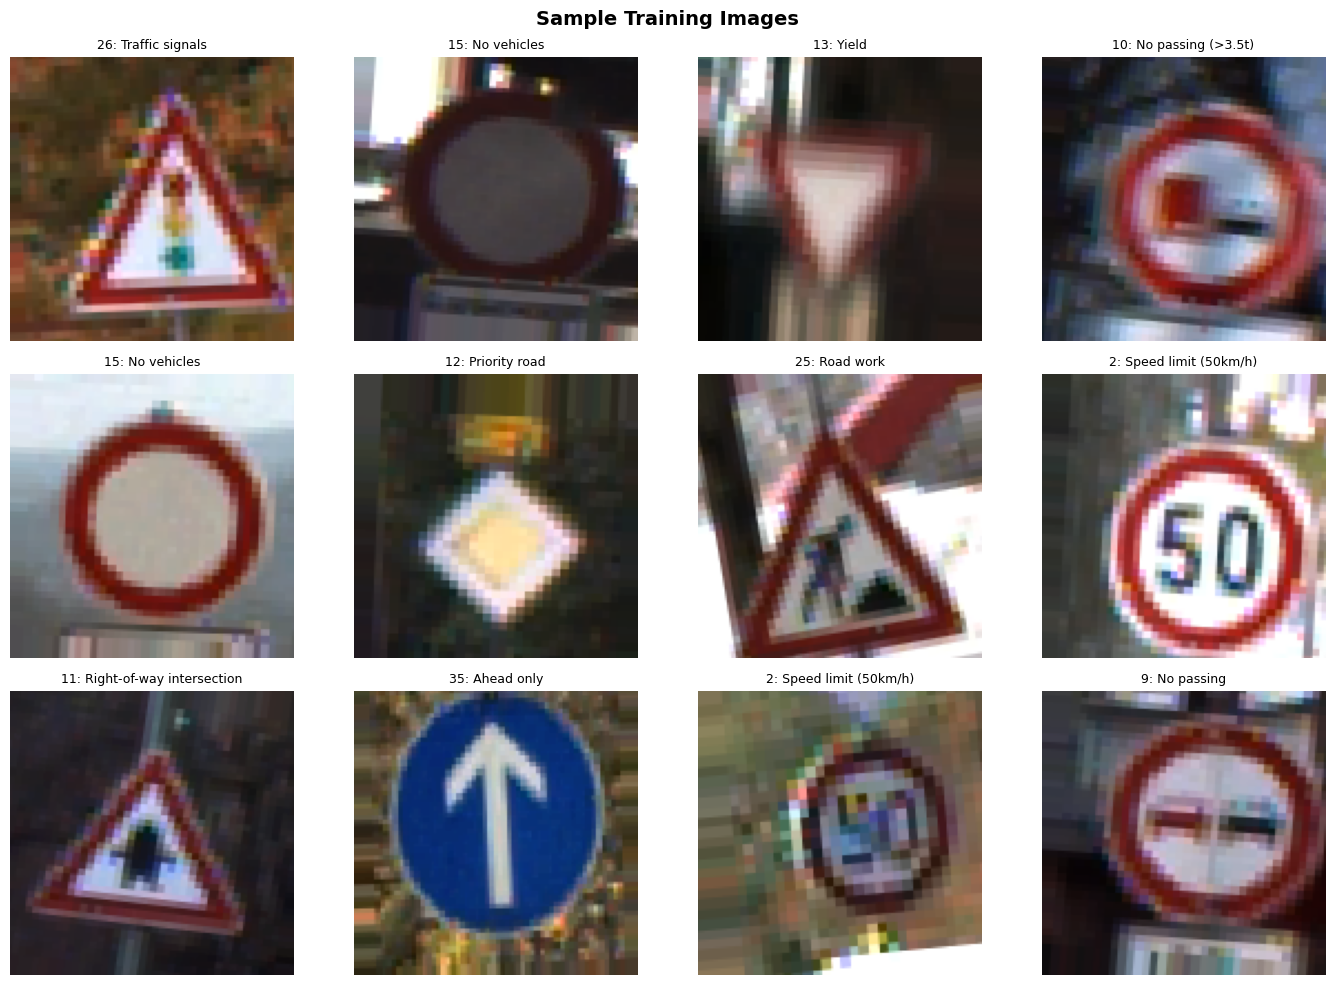

In [37]:
# ------------------------------------------------------
# Visualize Sample Images
# ------------------------------------------------------
# Display sample images to verify data loading and augmentation.

def show_sample_images(generator, class_names_map, num_samples=12):
    """
    Display a grid of sample images from the dataset.
    
    Args:
        generator: Keras ImageDataGenerator
        class_names_map: List mapping indices to class names
        num_samples: Number of images to display
    """
    images, labels = next(generator)
    
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        # Denormalize for display
        img_display = (images[i] - images[i].min()) / (images[i].max() - images[i].min())
        img_display = np.clip(img_display, 0, 1)
        
        axes[i].imshow(img_display)
        class_idx = np.argmax(labels[i])
        axes[i].set_title(f"{class_idx}: {class_names_map[class_idx]}", fontsize=9)
        axes[i].axis('off')
    
    plt.suptitle('Sample Training Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.MODEL_DIR, 'sample_images.png'), dpi=150)
    plt.show()


print("Displaying Sample Images")
show_sample_images(train_generator, CLASS_NAMES)
train_generator.reset()

In [38]:
# ------------------------------------------------------
# Compute Class Weights
# ------------------------------------------------------
# The GTSRB dataset is imbalanced. Class weights compensate by giving
# higher weight to underrepresented classes during training.
#
# Reference: King & Zeng (2001). Logistic Regression in Rare Events
# Data. Political Analysis, 9(2), 137-163.

print("Computing Class Weights")

train_labels = train_generator.classes

unique_classes = np.unique(train_labels)
class_weight_values = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_labels
)

# Convert to Python floats for JSON serialization
class_weights = {int(k): float(v) for k, v in zip(unique_classes, class_weight_values)}

print(f"Computed weights for {len(class_weights)} classes")

sorted_weights = sorted(class_weights.items(), key=lambda x: x[1], reverse=True)
print("Top 3 underrepresented classes:")
for class_idx, weight in sorted_weights[:3]:
    print(f"  {CLASS_NAMES[class_idx]}: weight = {weight:.2f}")

Computing Class Weights
Computed weights for 43 classes
Top 3 underrepresented classes:
  Speed limit (20km/h): weight = 4.34
  Dangerous curve left: weight = 4.34
  Go straight or left: weight = 4.34


In [39]:
# ------------------------------------------------------
# Build Model
# ------------------------------------------------------
# Construct the neural network using transfer learning with EfficientNetB0.
# The pretrained base extracts features, custom layers classify signs.
#
# Architecture based on transfer learning principles from
# alexstaravoitau/traffic-signs, updated to use EfficientNetB0.
# https://github.com/alexstaravoitau/traffic-signs
#
# Reference: Tan, M., & Le, Q. V. (2019). EfficientNet: Rethinking Model
# Scaling for Convolutional Neural Networks. ICML, 6105-6114.
#
# Reference: TensorFlow Team. Transfer Learning and Fine-tuning.
# https://www.tensorflow.org/tutorials/images/transfer_learning

def build_model(num_classes, input_shape):
    """
    Build the traffic sign recognition model using transfer learning.
    
    Architecture:
        - Base: EfficientNetB0 pretrained on ImageNet (frozen initially)
        - GlobalAveragePooling2D to reduce spatial dimensions
        - Dense layers with dropout for classification
        - Softmax output for 43-class classification
    
    Args:
        num_classes: Number of output classes (43 for GTSRB)
        input_shape: Input image shape (height, width, channels)
        
    Returns:
        tuple: (model, base_model) for training and fine-tuning
    """
    print("Building Model")
    
    # Load EfficientNetB0 pretrained on ImageNet
    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model for Phase 1
    base_model.trainable = False
    
    print(f"Base model: EfficientNetB0 ({len(base_model.layers)} layers)")
    print("Base model frozen for Phase 1")
    
    # Build classification head
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs, name='TrafficSignRecognizer')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Model compiled successfully")
    print(f"Output classes: {num_classes}")
    
    return model, base_model


model, base_model = build_model(NUM_CLASSES, Config.INPUT_SHAPE)

print("\nModel Summary")
model.summary()

Building Model
Base model: EfficientNetB0 (238 layers)
Base model frozen for Phase 1
Model compiled successfully
Output classes: 43

Model Summary
Model: "TrafficSignRecognizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)              

In [40]:
# ------------------------------------------------------
# Phase 1: Train Classification Head
# ------------------------------------------------------
# Train only the custom classification layers while keeping the
# EfficientNetB0 base frozen. This allows the model to learn traffic
# sign classification using pretrained image features.
#
# Two-phase training approach adapted from alexstaravoitau/traffic-signs
# https://github.com/alexstaravoitau/traffic-signs
#
# Reference: TensorFlow Team. Transfer Learning and Fine-tuning.
# https://www.tensorflow.org/tutorials/images/transfer_learning

print("Phase 1: Training Classification Head")
print(f"Base model: Frozen")
print(f"Epochs: {Config.EPOCHS_PHASE1}")

callbacks_phase1 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

history_phase1 = model.fit(
    train_generator,
    epochs=Config.EPOCHS_PHASE1,
    validation_data=valid_generator,
    callbacks=callbacks_phase1,
    class_weight=class_weights,
    verbose=1
)

phase1_best_acc = max(history_phase1.history['val_accuracy'])
print(f"\nPhase 1 Complete")
print(f"Best Validation Accuracy: {phase1_best_acc:.2%}")

Phase 1: Training Classification Head
Base model: Frozen
Epochs: 25
Epoch 1/25
613/613 [==============================] - 73s 116ms/step - loss: 8.3531 - accuracy: 0.4835 - val_loss: 4.7564 - val_accuracy: 0.6751 - lr: 5.0000e-04
Epoch 2/25
613/613 [==============================] - 69s 113ms/step - loss: 3.4881 - accuracy: 0.6628 - val_loss: 2.5895 - val_accuracy: 0.7374 - lr: 5.0000e-04
Epoch 3/25
613/613 [==============================] - 69s 113ms/step - loss: 2.2762 - accuracy: 0.7039 - val_loss: 2.0237 - val_accuracy: 0.7304 - lr: 5.0000e-04
Epoch 4/25
613/613 [==============================] - 69s 113ms/step - loss: 1.8645 - accuracy: 0.7161 - val_loss: 1.7428 - val_accuracy: 0.7582 - lr: 5.0000e-04
Epoch 5/25
613/613 [==============================] - 69s 112ms/step - loss: 1.7176 - accuracy: 0.7237 - val_loss: 1.6613 - val_accuracy: 0.7650 - lr: 5.0000e-04
Epoch 6/25
613/613 [==============================] - 69s 112ms/step - loss: 1.6447 - accuracy: 0.7256 - val_loss: 1.6146 

In [41]:
# ------------------------------------------------------
# Phase 2: Fine-Tuning
# ------------------------------------------------------
# Unfreeze top layers of EfficientNetB0 and continue training with a
# lower learning rate. This adapts the pretrained features specifically
# for traffic sign recognition.
#
# Fine-tuning approach adapted from alexstaravoitau/traffic-signs
# https://github.com/alexstaravoitau/traffic-signs
#
# Reference: TensorFlow Team. Transfer Learning and Fine-tuning.
# https://www.tensorflow.org/tutorials/images/transfer_learning

print("Phase 2: Fine-Tuning")

# Unfreeze top layers
base_model.trainable = True

fine_tune_from = len(base_model.layers) - Config.FINE_TUNE_LAYERS
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Unfroze {trainable_layers} layers for fine-tuning")

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Config.FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Learning rate: {Config.FINE_TUNE_LR}")
print(f"Epochs: {Config.EPOCHS_PHASE2}")

callbacks_phase2 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(Config.MODEL_DIR, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-8,
        verbose=1
    )
]

train_generator.reset()
valid_generator.reset()

history_phase2 = model.fit(
    train_generator,
    epochs=Config.EPOCHS_PHASE2,
    validation_data=valid_generator,
    callbacks=callbacks_phase2,
    class_weight=class_weights,
    verbose=1
)

phase2_best_acc = max(history_phase2.history['val_accuracy'])
print(f"\nPhase 2 Complete")
print(f"Best Validation Accuracy: {phase2_best_acc:.2%}")

Phase 2: Fine-Tuning
Unfroze 50 layers for fine-tuning
Learning rate: 5e-05
Epochs: 40
Epoch 1/40
613/613 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.8639
Epoch 1: val_accuracy improved from -inf to 0.90429, saving model to C:\Users\USER-PC\Documents\TrafficSignProject\models\best_model.h5
613/613 [==============================] - 72s 115ms/step - loss: 0.6982 - accuracy: 0.8639 - val_loss: 0.6781 - val_accuracy: 0.9043 - lr: 5.0000e-05
Epoch 2/40
613/613 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.9117
Epoch 2: val_accuracy improved from 0.90429 to 0.90804, saving model to C:\Users\USER-PC\Documents\TrafficSignProject\models\best_model.h5
613/613 [==============================] - 70s 114ms/step - loss: 0.5490 - accuracy: 0.9117 - val_loss: 0.6113 - val_accuracy: 0.9080 - lr: 5.0000e-05
Epoch 3/40
613/613 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.9318
Epoch 3: val_accuracy improved from 0.90804 to 0

Training History


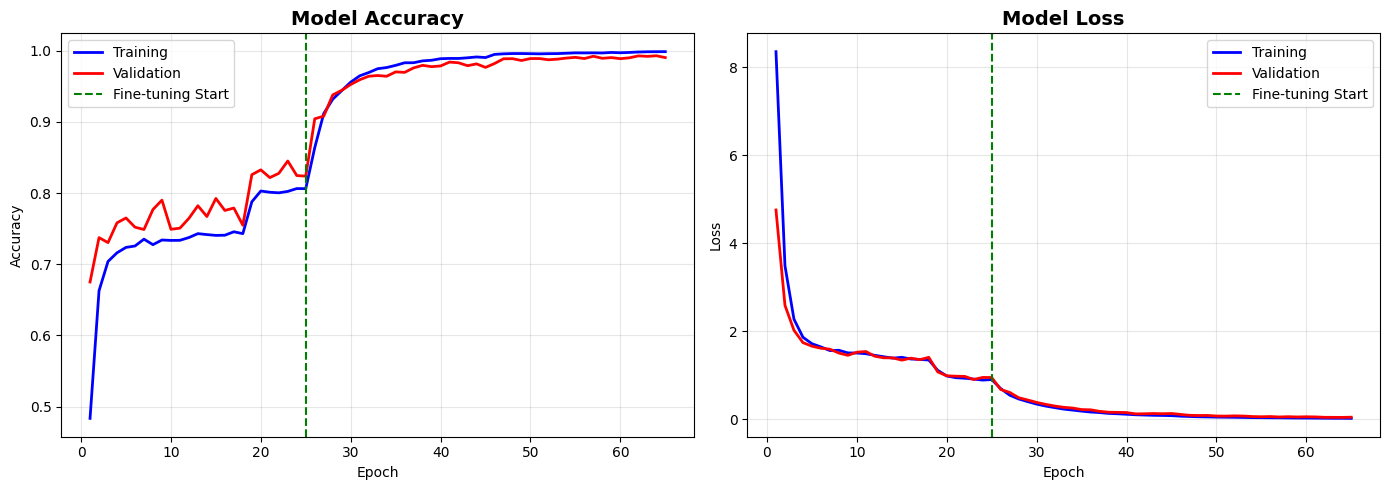

Best Overall Validation Accuracy: 99.28%


In [42]:
# ------------------------------------------------------
# Training History Visualization
# ------------------------------------------------------
# Plot training and validation metrics to assess model performance
# and identify potential overfitting.

def plot_training_history(history1, history2):
    """
    Plot accuracy and loss curves for both training phases.
    
    Args:
        history1: Training history from Phase 1
        history2: Training history from Phase 2
        
    Returns:
        float: Best validation accuracy achieved
    """
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    phase1_end = len(history1.history['accuracy'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(epochs, acc, 'b-', linewidth=2, label='Training')
    axes[0].plot(epochs, val_acc, 'r-', linewidth=2, label='Validation')
    axes[0].axvline(x=phase1_end, color='green', linestyle='--', label='Fine-tuning Start')
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, loss, 'b-', linewidth=2, label='Training')
    axes[1].plot(epochs, val_loss, 'r-', linewidth=2, label='Validation')
    axes[1].axvline(x=phase1_end, color='green', linestyle='--', label='Fine-tuning Start')
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(Config.MODEL_DIR, 'training_history.png'), dpi=150)
    plt.show()
    
    return max(val_acc)


print("Training History")
best_accuracy = plot_training_history(history_phase1, history_phase2)
print(f"Best Overall Validation Accuracy: {best_accuracy:.2%}")

In [43]:
# ------------------------------------------------------
# Test Set Evaluation
# ------------------------------------------------------
# Evaluate the trained model on the held-out test set to measure
# generalization performance on unseen data.

print("Test Set Evaluation")

test_generator.reset()

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")

Test Set Evaluation
198/198 [==============================] - 21s 109ms/step - loss: 0.5114 - accuracy: 0.8781

Test Loss: 0.5114
Test Accuracy: 87.81%


In [44]:
# ------------------------------------------------------
# Detailed Performance Metrics
# ------------------------------------------------------
# Compute precision, recall, and F1 score to provide a complete
# picture of classification performance across all classes.

print("Detailed Performance Metrics")

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Calculate weighted metrics (accounts for class imbalance)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\nPerformance Summary:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  Loss:      {test_loss:.4f}")

print("\nPer-Class Performance:")

unique_classes = sorted(set(y_true) | set(y_pred))
class_names_subset = [CLASS_NAMES[int(TRAIN_CLASS_NAMES[i])] for i in unique_classes]

print(classification_report(
    y_true, y_pred,
    labels=unique_classes,
    target_names=class_names_subset,
    zero_division=0
))

Detailed Performance Metrics
198/198 [==============================] - 6s 26ms/step

Performance Summary:
  Accuracy:  0.8781
  Precision: 0.8808
  Recall:    0.8781
  F1 Score:  0.8772
  Loss:      0.5114

Per-Class Performance:
                             precision    recall  f1-score   support

       Speed limit (20km/h)       0.49      0.55      0.52        60
       Speed limit (30km/h)       0.83      0.81      0.82       720
       Speed limit (50km/h)       0.82      0.75      0.78       750
       Speed limit (60km/h)       0.70      0.78      0.74       450
       Speed limit (70km/h)       0.81      0.88      0.84       660
       Speed limit (80km/h)       0.88      0.70      0.78       630
End of speed limit (80km/h)       0.99      0.91      0.95       150
      Speed limit (100km/h)       0.79      0.86      0.82       450
      Speed limit (120km/h)       0.82      0.85      0.84       450
                 No passing       0.96      0.97      0.97       480
         

Confusion Matrix


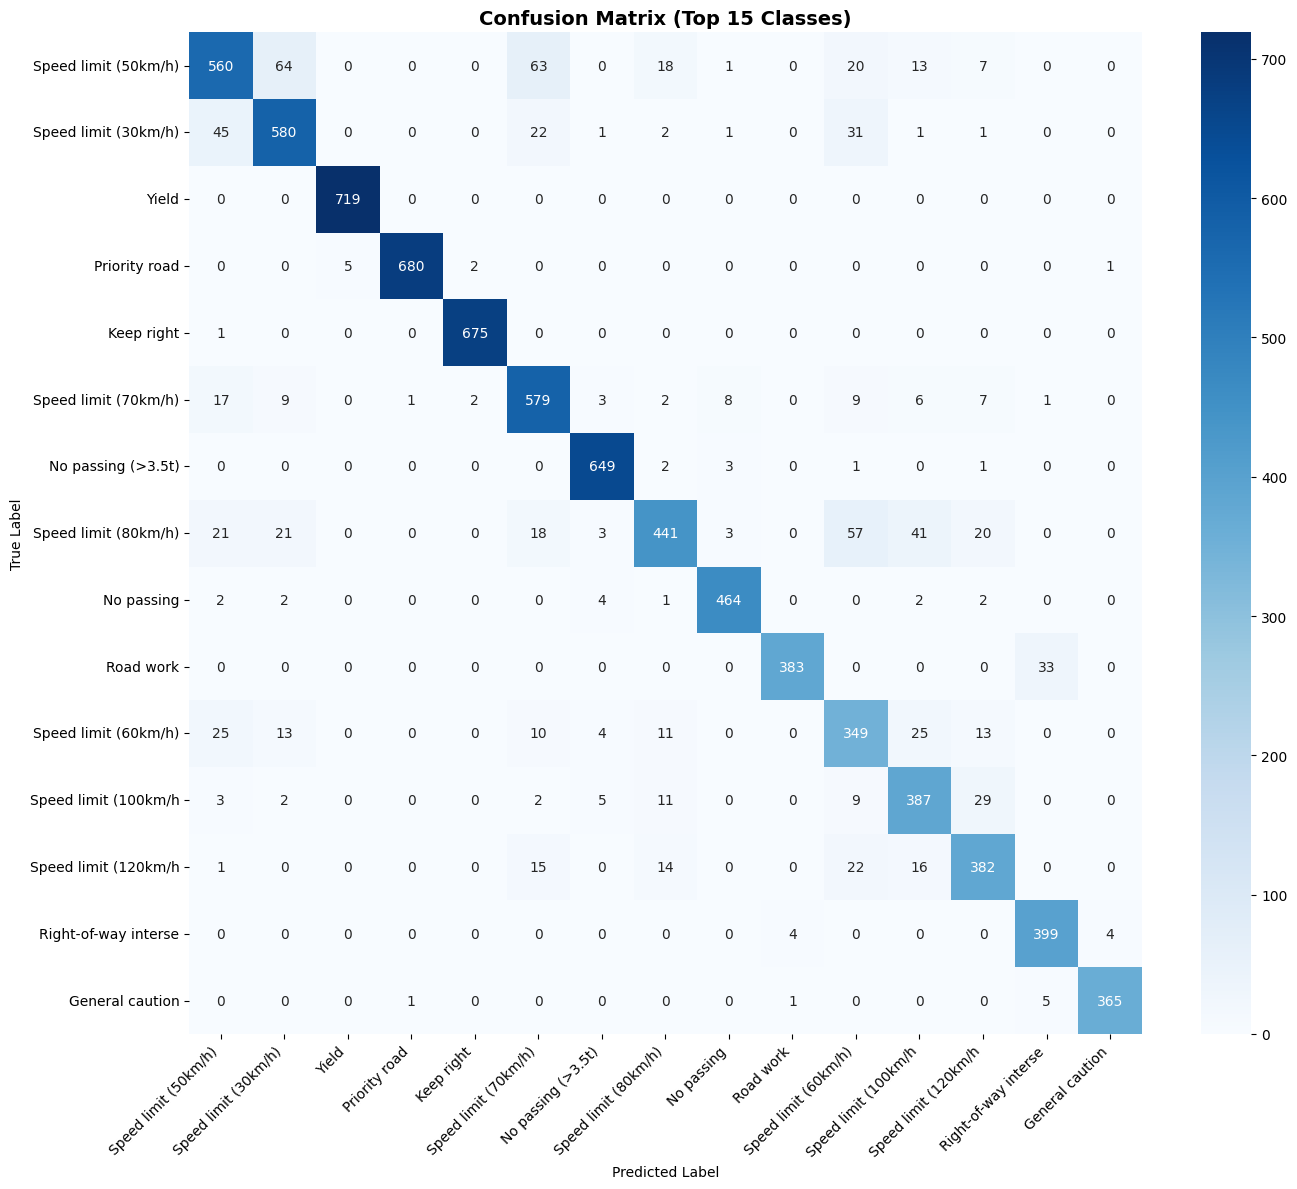

In [45]:
# ------------------------------------------------------
# Confusion Matrix
# ------------------------------------------------------
# Visualize prediction distribution across classes to identify
# which signs the model confuses with each other.

def plot_confusion_matrix(y_true, y_pred, class_names, top_n=15):
    """
    Plot confusion matrix for the top N most frequent classes.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        class_names: List of human-readable class names
        top_n: Number of classes to include
    """
    class_counts = Counter(y_true)
    top_classes = [cls for cls, _ in class_counts.most_common(top_n)]
    
    mask = np.isin(y_true, top_classes)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    class_to_idx = {cls: i for i, cls in enumerate(top_classes)}
    y_true_mapped = np.array([class_to_idx.get(y, -1) for y in y_true_filtered])
    y_pred_mapped = np.array([class_to_idx.get(y, -1) for y in y_pred_filtered])
    
    valid_mask = (y_true_mapped >= 0) & (y_pred_mapped >= 0)
    y_true_mapped = y_true_mapped[valid_mask]
    y_pred_mapped = y_pred_mapped[valid_mask]
    
    cm = confusion_matrix(y_true_mapped, y_pred_mapped)
    
    top_class_names = [class_names[int(TRAIN_CLASS_NAMES[i])][:20] for i in top_classes]
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=top_class_names,
        yticklabels=top_class_names
    )
    plt.title(f'Confusion Matrix (Top {top_n} Classes)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.MODEL_DIR, 'confusion_matrix.png'), dpi=150)
    plt.show()


print("Confusion Matrix")
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, top_n=15)

In [46]:
# ------------------------------------------------------
# Save Model
# ------------------------------------------------------
# Save the trained model and class information.

print("Saving Model")

# Save weights only (avoids JSON serialization issues)
weights_path = os.path.join(Config.MODEL_DIR, 'traffic_sign_model_weights.h5')
model.save_weights(weights_path)
print(f"Weights saved: {weights_path}")

# Save class info
class_info = {
    'class_indices': TRAIN_CLASS_NAMES,
    'class_names': CLASS_NAMES,
    'num_classes': NUM_CLASSES,
    'image_size': list(Config.IMAGE_SIZE)
}
class_info_path = os.path.join(Config.MODEL_DIR, 'class_info.json')
with open(class_info_path, 'w') as f:
    json.dump(class_info, f, indent=2)
print(f"Class info saved: {class_info_path}")

print(f"\nAll files saved to: {Config.MODEL_DIR}")

Saving Model
Weights saved: C:\Users\USER-PC\Documents\TrafficSignProject\models\traffic_sign_model_weights.h5
Class info saved: C:\Users\USER-PC\Documents\TrafficSignProject\models\class_info.json

All files saved to: C:\Users\USER-PC\Documents\TrafficSignProject\models


In [47]:
# ------------------------------------------------------
# Final Results
# ------------------------------------------------------

print("\n")
print("Final Results")
print("-" * 40)
print(f"Dataset: GTSRB (German Traffic Sign Recognition Benchmark)")
print(f"Classes: {NUM_CLASSES}")
print(f"Test Samples: {test_generator.samples}")
print("")
print("Performance Metrics:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  Loss:      {test_loss:.4f}")
print("")
print(f"Model saved to: {Config.MODEL_DIR}")



Final Results
----------------------------------------
Dataset: GTSRB (German Traffic Sign Recognition Benchmark)
Classes: 43
Test Samples: 12630

Performance Metrics:
  Accuracy:  0.8781
  Precision: 0.8808
  Recall:    0.8781
  F1 Score:  0.8772
  Loss:      0.5114

Model saved to: C:\Users\USER-PC\Documents\TrafficSignProject\models
